# Echo hiding watermarking

In [18]:
import librosa
import numpy as np
import scipy
from matplotlib import pyplot as plt

In [19]:
# read audio data
x, sr = librosa.load("sample.wav",sr=None)

# frame segmentation
sig_length = len(x)
frame_length = 4096
hop_length = 2048
overlap = frame_length - hop_length
Nframe = int( (sig_length-overlap) / hop_length)

# Hann window
win = scipy.signal.windows.hann(frame_length)

# message generation
if_repetitive_coding = False
if if_repetitive_coding:
    repeat = 3
    msg_len = int(Nframe/repeat)
else:
    repeat = 1
    msg_len = Nframe
        
msg = np.random.randint(2, size=msg_len)
print(msg)

[0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0
 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1
 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1]


In [20]:
# echo kernels
delta1 = 100
delta0 = 120

alpha = 0.2 #echo amplitude
delay = 4 # negative echo

prev1 = np.zeros(frame_length) #for positive single
prev2 = np.zeros(frame_length) #for pos/neg pair
prev3 = np.zeros(frame_length) #for back/forward

## watermark embedding

In [24]:
embedded_x1, embedded_x2, embedded_x3 = np.copy(x), np.copy(x), np.copy(x)
for frame_idx in range(Nframe):
    start = librosa.frames_to_samples(frame_idx,hop_length=hop_length)
    frame = x[start:start+frame_length]
    
    if frame_idx//repeat < msg_len:
        msg_bit = msg[frame_idx//repeat]
        delta = delta1 if msg_bit==1 else delta0
    else:
        delta = 0
    
    echo_p = alpha * np.append(np.zeros(delta), frame[:frame_length-delta])
    echo_n = -alpha * np.append(np.zeros(delta+delay), frame[:frame_length-delta-delay])
    echo_f = alpha * np.append(frame[delta:], np.zeros(delta))
    
    echoed_frame1 = frame + echo_p
    echoed_frame2 = frame + echo_p + echo_n
    echoed_frame3 = frame + echo_p + echo_f
    
    # windowing and smoothing
    windowed_frame1 = echoed_frame1 * win
    windowed_frame2 = echoed_frame2 * win
    windowed_frame3 = echoed_frame3 * win
    
    prev_ovlp_begin, curr_non_ovlp_begin = hop_length, frame_length - hop_length
    curr_ovlp_end = frame_length - hop_length
    
    smoothed_frame1 = np.append(prev1[prev_ovlp_begin:] + windowed_frame1[:curr_ovlp_end],
                                windowed_frame1[curr_non_ovlp_begin:])
    smoothed_frame2 = np.append(prev1[prev_ovlp_begin:] + windowed_frame2[:curr_ovlp_end],
                                windowed_frame1[curr_non_ovlp_begin:])
    smoothed_frame3 = np.append(prev1[prev_ovlp_begin:] + windowed_frame3[:curr_ovlp_end],
                                windowed_frame1[curr_non_ovlp_begin:])
    
    prev1 = smoothed_frame1
    prev2 = smoothed_frame2
    prev3 = smoothed_frame3
    
    embedded_x1[start:start+frame_length] = smoothed_frame1
    embedded_x2[start:start+frame_length] = smoothed_frame2
    embedded_x3[start:start+frame_length] = smoothed_frame3

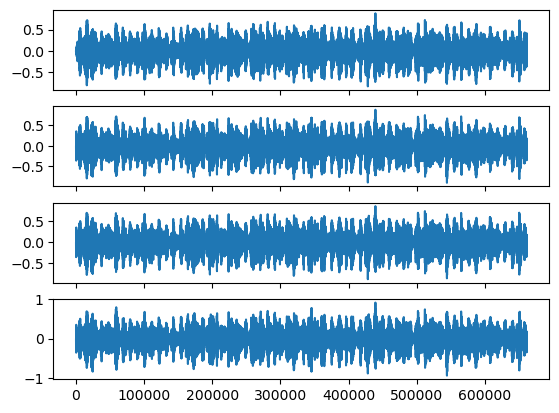

In [31]:
ax1 = plt.subplot(411)
plt.plot(x)
plt.tick_params('x', labelbottom=False)
ax2 = plt.subplot(412, sharex = ax1)
plt.plot(embedded_x1)
plt.tick_params('x', labelbottom=False)
ax3 = plt.subplot(413,sharex = ax1)
plt.plot(embedded_x2)
plt.tick_params('x', labelbottom=False)
ax4 = plt.subplot(414, sharex = ax1)
plt.plot(embedded_x3)